In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import matplotlib as mpl

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['font.family']      = 'Helvetica'

In [2]:
# SUBFUNCTIONS

def merge_capacity_data(results_dict,relative=False):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        if not relative:
            df = results_dict[k].results_capacities
        else:
            df = results_dict[k].results_capacity_change
        capacities = capacities.append(df,ignore_index=True)
    return capacities


def merge_cost_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    costs = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_costs
        costs = costs.append(df,ignore_index=True)
    return costs
    
    
def map_territory(df,on):
    '''Map territory onto dataframe
    '''
    # add regions
    df['territory'] = np.nan
    df.loc[df[on].str.contains('jordan'),'territory']  = 'Jordan'
    df.loc[df[on].str.contains('israel'),'territory']  = 'Israel'
    df.loc[df[on].str.contains('west'),'territory']    = 'West Bank'
    df.loc[df[on].str.contains('gaza'),'territory']    = 'Gaza'
    df.loc[df[on].str.contains('super'),'territory']   = 'Shortage'
    df.loc[df[on].str.contains('egypt'),'territory']   = 'Egypt'
    return df


def map_technology(df,on):
    '''Map technology onto dataframe
    '''
    df['technology'] = np.nan
    df.loc[df.from_id.str.contains('solar'),'technology']       = 'Solar'
    df.loc[df.from_id.str.contains('coal'),'technology']        = 'Coal'
    df.loc[df.from_id.str.contains('diesel'),'technology']      = 'Diesel'
    df.loc[df.from_id.str.contains('ccgt'),'technology']        = 'Gas'
    df.loc[df.from_id.str.contains('gas'),'technology']         = 'Gas'
    df.loc[df.from_id.str.contains('shale'),'technology']       = 'Shale'
    df.loc[df.from_id.str.contains('wind'),'technology']        = 'Wind'
    df.loc[df.from_id.str.contains('storage'),'technology']     = 'Storage'
    df.loc[df.from_id.str.contains('super'),'technology']       = 'Shortage'
    return df


def map_sox_emissions(df,on):
    '''Estimate SOx emissions in tonnes
    '''
    df['sox'] = df[on] * df['technology'].map(sox) * 10**-6
    return df


def map_nox_emissions(df,on):
    '''Estimate NOx emissions in tonnes
    '''
    df['nox'] = df[on] * df['technology'].map(nox) * 10**-6
    return df


def map_co2_emissions(df,on):
    '''Estimate CO2 emissions in tonnes
    '''
    df['co2'] = df[on] * df['technology'].map(co2) * 10**-6
    return df

def map_water_use(df,on):
    df['water_use'] = df[on] * df['technology'].map(water_use)
    return df

## Load scenario results

In [3]:
file = open('../outputs/results/model_run_results.pkl','rb')
results = pickle.load(file)
file.close()

In [4]:
merged_flows = pd.DataFrame()
for k in results.keys():
    sn = get_source_nodes(results[k].nodes).name.to_list()
    # get source flows, but remove all those going to curtailment
    df = results[k].results_edge_flows.loc[(results[k].results_edge_flows.from_id.isin(sn)) & \
                                           (results[k].results_edge_flows.to_id != 'curtailment') & \
                                           (~results[k].results_edge_flows.from_id.str.contains('egypt_generation')) & \
                                           (~results[k].results_edge_flows.to_id.str.contains('battery_storage'))
                                          ]
    df = df.drop(['to_id','commodity','timestep','hour'],axis=1)
    # compute daily sums
    df = df.groupby(by=['from_id','day','month','year','scenario']).sum().reset_index()
    df = map_territory(df,on='from_id')
    df = map_technology(df,on='from_id')
    # append into one df
    merged_flows = merged_flows.append(df,ignore_index=True)

merged_flows = map_sox_emissions(merged_flows,on='value')
merged_flows = map_nox_emissions(merged_flows,on='value')
merged_flows = map_co2_emissions(merged_flows,on='value')
merged_flows = map_water_use(merged_flows,on='value')

# compute co2 intensity
merged_flows['carbon_intensity'] = merged_flows['co2'] / merged_flows['value']  * 10**6

merged_flows

,from_id,day,month,year,scenario,value,territory,technology,sox,nox,co2,water_use,carbon_intensity
0,gaza_diesel,1,1,2030,BAS,0.000000,Gaza,Diesel,0.0,0.0,0.0,0.0,NaN
1,gaza_diesel,1,2,2030,BAS,0.000000,Gaza,Diesel,0.0,0.0,0.0,0.0,NaN
2,gaza_diesel,1,3,2030,BAS,0.000000,Gaza,Diesel,0.0,0.0,0.0,0.0,NaN
3,gaza_diesel,1,4,2030,BAS,0.000000,Gaza,Diesel,0.0,0.0,0.0,0.0,NaN
4,gaza_diesel,1,5,2030,BAS,0.000000,Gaza,Diesel,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40145,west_bank_wind,31,5,2030,COO,132.594362,West Bank,Wind,0.0,0.0,0.0,0.0,0.0
40146,west_bank_wind,31,7,2030,COO,118.794362,West Bank,Wind,0.0,0.0,0.0,0.0,0.0
40147,west_bank_wind,31,8,2030,COO,103.844362,West Bank,Wind,0.0,0.0,0.0,0.0,0.0
40148,west_bank_wind,31,10,2030,COO,87.500000,West Bank,Wind,0.0,0.0,0.0,0.0,0.0


In [5]:
# compute daily sums per scenario
average_values = merged_flows.groupby(by=['scenario','day','month','year']).mean().reset_index()

# compute monthly averages for each scenario
#average_values = merged_flows.groupby(by=['scenario','month','year']).mean().reset_index()

# adjust units to average monthly grams/day
average_values['nox'] = average_values['nox'] * 10**6
average_values['nox'] = average_values['nox'].round()

average_values['sox'] = average_values['sox'] * 10**6
average_values['sox'] = average_values['sox'].round()

# kg per day
average_values['co2'] = average_values['co2'] * 10**3
average_values['co2'] = average_values['co2'].round()

# grams per kWh
average_values['carbon_intensity'] = average_values['co2'] / average_values['value'] * 10**3

# add month categorical
average_values.loc[average_values.month.isin([1,2,3,4]),'season'] = 'Jan-Apr'
average_values.loc[average_values.month.isin([5,6,7,8,9]),'season'] = 'May-Sep'
average_values.loc[average_values.month.isin([10,11,12]),'season'] = 'Oct-Dec'

# melt
average_values = average_values.melt(id_vars=['scenario','season'], 
                                     value_vars=['sox','nox','co2','water_use','carbon_intensity']
                                    )

average_values.head(3)

,scenario,season,variable,value
0,BAS,Jan-Apr,sox,1343.0
1,BAS,Jan-Apr,sox,1321.0
2,BAS,Jan-Apr,sox,1139.0


In [6]:
# PLOT FOR COO ONLY
coo_average_values = average_values[average_values.scenario == 'COO']

for v in coo_average_values.variable.unique():
    # compute BAS average
    bas_avg = average_values.groupby(by=['scenario','variable']).mean().loc['BAS',v].values[0]
    # compute pctg difference
    coo_average_values.loc[(coo_average_values.variable == v),'value'] = \
        (coo_average_values.loc[(coo_average_values.variable == v),'value'] - bas_avg)/bas_avg * 100

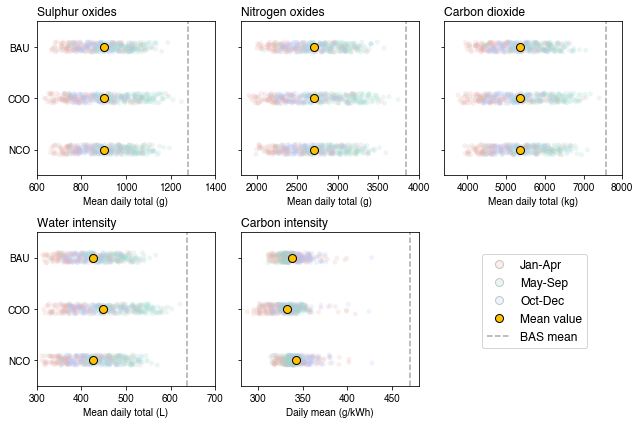

In [7]:
# get bas average
scenarios_to_plot = average_values[average_values.scenario.isin(['BAU','COO','NCO'])]

g = sns.FacetGrid(scenarios_to_plot, 
                  col="variable", 
                  #hue='season',
                  col_wrap=3,
                  sharex=False,
                  #palette='Set2',
                 )

g.map(sns.stripplot, 
      "value",
      "scenario", 
      'season',
      alpha=0.2,
      palette=['#e6b0aa','#a2d9ce','#b3c4ff'],
      s=5,
     )

g.map(sns.boxplot, 
      "value",
      "scenario", 
      showmeans=True,
      #meanline=True,
      meanprops={'color': 'red',
                 'marker':'o',
                 'markerfacecolor':'#ffc100',
                 'markeredgecolor':'black',
                 'ls': '-', 
                 'lw': 2, 
                 'markersize':8,
                },
      medianprops={'visible': False},
      whiskerprops={'visible': False},
      zorder=10,
      showfliers=False,
      showbox=False,
      showcaps=False,
     )

axes = g.axes.flatten()

#titles
for i in [0,1,2,3,4]:
    axes[i].set_title("",loc='center',fontweight='bold')

axes[0].set_title("Sulphur oxides",loc='left',fontweight='bold')
axes[1].set_title("Nitrogen oxides",loc='left',fontweight='bold')
axes[2].set_title("Carbon dioxide",loc='left',fontweight='bold')
axes[3].set_title("Water intensity",loc='left',fontweight='bold')
axes[4].set_title("Carbon intensity",loc='left',fontweight='bold')

#xlabels
axes[0].set_xlabel("Mean daily total (g)")
axes[1].set_xlabel("Mean daily total (g)")
axes[2].set_xlabel("Mean daily total (kg)")
axes[3].set_xlabel("Mean daily total (L)")
axes[4].set_xlabel("Daily mean (g/kWh)")

#ylabels
axes[0].set_ylabel("")
axes[3].set_ylabel("")

#xlimits
xlimits = [[600,1400],[1800,4000],[3400,8000],[300,700],[280,480]]
for i in range(0,len(xlimits)):
    axes[i].set_xlim(xlimits[i])

# plot BAS averages
linecolor='darkgray'
linestyle='--'
axes[0].axvline(average_values.groupby(by=['scenario','variable']).mean().loc['BAS','sox'].values,color=linecolor,linestyle=linestyle)
axes[1].axvline(average_values.groupby(by=['scenario','variable']).mean().loc['BAS','nox'].values,color=linecolor,linestyle=linestyle)
axes[2].axvline(average_values.groupby(by=['scenario','variable']).mean().loc['BAS','co2'].values,color=linecolor,linestyle=linestyle)
axes[3].axvline(average_values.groupby(by=['scenario','variable']).mean().loc['BAS','water_use'].values,color=linecolor,linestyle=linestyle)
axes[4].axvline(average_values.groupby(by=['scenario','variable']).mean().loc['BAS','carbon_intensity'].values,color=linecolor,linestyle=linestyle)

# padding
plt.tight_layout()

# legend
#g.add_legend(title='Season',bbox_to_anchor=(0.8,0.3))
# plt.setp(g._legend.get_title(), fontsize=16)
# plt.setp(g._legend.get_texts(), fontsize=12)



legend_elements = [Line2D([0], [0], marker='o', color='none', label='Jan-Apr',
                          markerfacecolor='#e6b0aa', markersize=8,alpha=0.2),
                   Line2D([0], [0], marker='o', color='none', label='May-Sep',
                          markerfacecolor='#a2d9ce', markersize=8,alpha=0.2),
                   Line2D([0], [0], marker='o', color='none', label='Oct-Dec',
                          markerfacecolor='#b3c4ff', markersize=8,alpha=0.2),
                   Line2D([0], [0], marker='o', color='none', label='Mean value',
                          markerfacecolor='#ffc100', markersize=8),
                   Line2D([0], [0], marker='', color='darkgray', label='BAS mean',
                          markerfacecolor='#ffc100', markersize=8, linestyle='--'),
                  ]

plt.legend(handles=legend_elements, 
           loc='center', 
           bbox_to_anchor=(1.65,0.55),
           frameon=True,
           #title='Legend',
           fontsize="large"
          )

# spines
sns.despine(left=False, bottom=False, top=False,right=False)

# savefig
plt.savefig('../outputs/figures/oms_emissions_factors.png',dpi=350,bbox_inches='tight')